## Label drift detector

This notebook follows the example from [river](https://riverml.xyz/0.11.1/examples/concept-drift-detection/).
However, instead of using the river library directly, it detects drift using 
`drifting`. 



Let's prepare the data that will imitate the labels

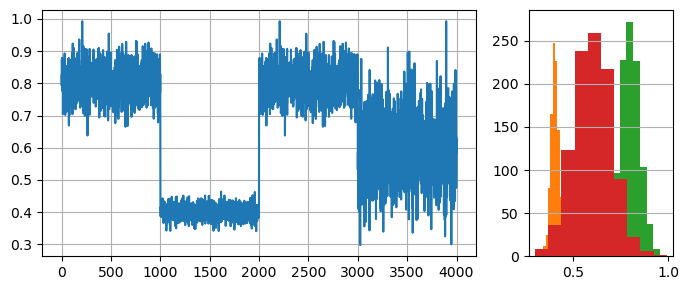

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generate data for 3 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

# Concatenate data to simulate a data stream with 2 drifts
stream = np.concatenate((dist_a, dist_b, dist_a, dist_c))

# Auxiliary function to plot the data
def plot_data(dist_a, dist_b, dist_c, drifts=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_b, label=r'$dist_b$')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_c, label=r'$dist_c$')
    if drifts is not None:
        for drift_detected in drifts:
            ax1.axvline(drift_detected, color='red')
    plt.show()

plot_data(dist_a, dist_b, dist_c)


train_data = dist_a
test_data = stream

We can see 3 kinds of predictions. We will fit the drift detector on the first 
distribution, and test it on the two following, putting the training data
in between.

We train the model:

In [3]:

import requests
from mlserver.codecs import NumpyRequestCodec

detector_name = "LabelDriftDetector"
params = {
    "detector_name": detector_name,
    "drift_type": "label",
}
training_request = NumpyRequestCodec.encode_request(train_data)

endpoint = "http://localhost:8080/v2/models/fit/"
response = requests.post(endpoint, json=training_request.dict(), params=params)

Load the model after training:

In [4]:

endpoint = f"http://localhost:8080/v2/repository/models/{detector_name}/load"
response = requests.post(endpoint)


Detect drift sending the labels one by one: 

Change detected at index 1055
Change detected at index 2047
Change detected at index 3071


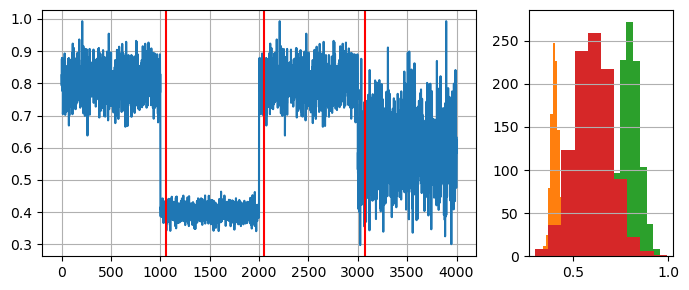

In [5]:

endpoint = f"http://localhost:8080/v2/models/{detector_name}/infer"

drifts = []
for i, val in enumerate(test_data):
    test_request = NumpyRequestCodec.encode_request(val)
    response = requests.post(endpoint, json=test_request.dict(), params=params).json()
    # print(response)
    if response["outputs"][0]["data"][0]:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i}')
        drifts.append(i)
plot_data(dist_a, dist_b, dist_c, drifts)